Hyderabad City is capital of Telangana state in India. The economy of the capital is based on traditional manufacturing, Information Technology and tourism
Many IT campuses have been developed in areas such as Madhapur, Gachibowli, Kondapur and Uppal. As more and more Information Technology Investment Region (ITIR) are coming up and offices are setup, there is a constant need amenities for people who work and live in that area. 
It is significantly necessary to understand landscape of amenities/venues currently existing in the neighborhoods of Hyderabad so that any new venue can be opened by entrepreneurs to serve right necessity of the new people who started working or some of them could have moved to these neighborhoods. 

As the first part of this project, neighborhood, also knows as Ward, data is scraped from Wiki page 'https://en.wikipedia.org/wiki/List_of_Hyderabad_Corporation_wards'. Corresponding latitude and longitudes are obtained using Google GeoCoding APs. Foursquare API is used to get a list of venues for each corresponding neighbodhoods to get an idea about top 10 most common venues in those neighborhood. To begin this analysis, neighborhood clusters will be created and their venues analysed in similarity terms.

Once the most frequent venues per neighborhood get extracted, top 10 most common venues are selected for each neighborhood. As there are high number of venues, only the top 10 most common venues are selected and this data is converted to onehot encoding. This onehot encoded data is used in K-Means clustering learning algorithm to train the model to identify right clusters of the venues.

This project uses Python 3.6 programing language for all the functions such data retrieving, data cleansing, visualization of neighboboohds on maps, training the model using K-Means algorithm to obtain venue clusters, and visualizing the clusters on the map. Below is the code for the project and is summarized in CapstoneAssignment-Final.pdf.

### Import required Libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


### Read source data from wiki page, convert to a dataframe and clean up dataframe to use

In [4]:
webPage = requests.get("https://en.wikipedia.org/wiki/List_of_Hyderabad_Corporation_wards") #Download page
html = webPage.text                                                                       #Get HTML code
tableInit = html.find('<table class="wikitable">')                               #Locate index for beginning of the table
tableFinal = html.find('</table>')                                                        #Locate index for ending of the table
htmlTable = html[tableInit:tableFinal]                                                    #HTML table extracted
table = pd.read_html(htmlTable, header = 0)[0]                                            #From HTML to Pandas data frame

print("Table has been downloaded succesfully!")
table.head()


Table has been downloaded succesfully!


,Zone,Circle,Ward
0,L. B. Nagar (East Zone),1. Kapra,1. Kapra
1,L. B. Nagar (East Zone),1. Kapra,2. Dr AS Rao Nagar
2,L. B. Nagar (East Zone),1. Kapra,3. Cherlapalli
3,L. B. Nagar (East Zone),1. Kapra,4. Meerpet HB Colony
4,L. B. Nagar (East Zone),1. Kapra,5. Mallapur


### Clean up the dataframe to get the list of the Wards/Neighborhoods

In [5]:
table1=table
sub ='.'
start = 0
table1["Indexes"]= table1["Circle"].str.find(sub,start) 
table1["IndexesW"]= table1["Ward"].str.find(sub,start) 
table1['Circle'] = table1.apply(lambda table1:table1['Circle'][table1['Indexes']+2:], axis=1)
table1['Ward'] = table1.apply(lambda table1:table1['Ward'][table1['IndexesW']+2:], axis=1)

In [6]:
Wards = table1.drop(['Indexes','IndexesW','Zone','Circle'], axis=1)
print("List of Wards/Neighborhoods created")

Wards.head()


List of Wards/Neighborhoods created


,Ward
0,Kapra
1,Dr AS Rao Nagar
2,Cherlapalli
3,Meerpet HB Colony
4,Mallapur


In [7]:
Wards.shape

(151, 1)

### Get the coordinates for all the Wards/Neighborhoods using Google Maps Geocoding API

In [8]:
API_KEY="---------------------------------------"

In [9]:
latitudes = [] # Initializing the latitude array
longitudes = [] # Initializing the longitude array

for nbd in Wards['Ward']: 
    place_name = nbd + ",Hyderabad,India" # Formats the place name
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(place_name, API_KEY) # Gets the proper url to make the API call
    obj = json.loads(requests.get(url).text) # Loads the JSON file in the form of a python dictionary
    
    results = obj['results'] # Extracts the results information out of the JSON file
    lat = results[0]['geometry']['location']['lat'] # Extracts the latitude value
    lng = results[0]['geometry']['location']['lng'] # Extracts the longitude value
    
    latitudes.append(lat) # Appending to the list of latitudes
    longitudes.append(lng) # Appending to the list of longitudes

### Add  latitude and longitude to the Neighborhoods in the dataframe

In [10]:
Wards['Latitude'] = latitudes
Wards['Longitude'] = longitudes

In [47]:
Wards.shape

(151, 3)

### Checking if there are any collisions amoung lat,lng for Neighborhoods

In [14]:
col = 0
explored_lat_lng = []
for lat, lng, neighbourhood in zip(Wards['Latitude'], Wards['Longitude'], Wards['Ward']):
    if (lat, lng) in explored_lat_lng:
        col = col + 1
    else:
        explored_lat_lng.append((lat, lng))

print("Collisions : ", col)

Collisions :  1


### Create a map of Hyderabad with all the neighborhoods using Folium

In [15]:
hyd_lat = 17.3850
hyd_lng = 78.4867

# Creates map of Hyderabad using latitude and longitude values
map_hyderabad = folium.Map(location=[hyd_lat, hyd_lng], zoom_start=12)

# Add markers to map
for lat, lng, neighbourhood in zip(Wards['Latitude'], Wards['Longitude'], Wards['Ward']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyderabad)  
    
map_hyderabad

### FourSquare API Credentials

In [470]:
CLIENT_ID = '-----------------------------------------------' # your Foursquare ID
CLIENT_SECRET = '-----------------------------------------------' # your Foursquare Secret
VERSION = '20200402'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



In [17]:
# Gets the name of the category

def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Using the FourSquare API to get list of venues for all the neighbourhoods

In [18]:
explore_df_list = []

for i, nbd_name in enumerate(Wards['Ward']):  
    
    try :
        ### Getting the data of neighbourhood
        nbd_name = Wards.loc[i, 'Ward']
        nbd_lat = Wards.loc[i, 'Latitude']
        nbd_lng = Wards.loc[i, 'Longitude']

        radius = 1000 # Setting the radius as 1000 metres
        LIMIT = 30 # Getting the top 30 venues

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}\
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flattens JSON

        # Filtering the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Renaming the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns
         # Gets the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Gets the data required
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nbd_name, nbd_lat, nbd_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

### Creating a new dataframe for clustering 

In [19]:
explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Kapra,17.488525,78.568172,Big Bull Bakery,Bakery,17.492283,78.565074
1,Kapra,17.488525,78.568172,Axis Bank ATM,ATM,17.492400,78.565100
2,Kapra,17.488525,78.568172,Vineeth's Oven,Bakery,17.493317,78.569046
3,Kapra,17.488525,78.568172,Pranoy's Stove,Spanish Restaurant,17.493317,78.569046
4,Kapra,17.488525,78.568172,Apollo Pharmacy,Pharmacy,17.490776,78.573792


In [46]:
explore_df.shape

(1422, 7)

### Count of venues  by neighborhood

In [20]:
explore_df.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
Neighbourhood,,,,,,
- Alwal,6,6,6,6,6,6
- Macha Bollaram,5,5,5,5,5,5
36 - Neredmet,4,4,4,4,4,4
37 - Vinayakanagar,30,30,30,30,30,30
38 - Moula-Ali,5,5,5,5,5,5
39 - East Anandbagh,7,7,7,7,7,7
40 - Malkajgiri,11,11,11,11,11,11
41 - Gautham Nagar,26,26,26,26,26,26
48 - Ramgopal Pet,30,30,30,30,30,30


In [77]:
print('There are {} uniques categories.'.format(len(explore_df['Venue Category'].unique())))

There are 154 uniques categories.


### one-hot encoding to analyze neighbourhoods

In [21]:
hyderabad_onehot = pd.get_dummies(explore_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hyderabad_onehot['Neighbourhood'] = explore_df['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [hyderabad_onehot.columns[-1]] + list(hyderabad_onehot.columns[:-1])
hyderabad_onehot = hyderabad_onehot[fixed_columns]
hyderabad_onehot.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport,Airport Service,American Restaurant,Andhra Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cable Car,Cafeteria,Café,Candy Store,Chaat Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Lake,Light Rail Station,Lighting Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Pub,Resort,Restaurant,River,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Court,Theme Park,Train Station,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store,Zoo
0,Kapra,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kapra,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kapra,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kapra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kapra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
hyderabad_onehot.shape

(1422, 155)

### Group by neighborhood and get the mean ocurrence of each venue category

In [51]:
hyderabad_grouped = hyderabad_onehot.groupby('Neighbourhood').mean().reset_index()
hyderabad_grouped.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport,Airport Service,American Restaurant,Andhra Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cable Car,Cafeteria,Café,Candy Store,Chaat Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Lake,Light Rail Station,Lighting Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,North Indian Restaurant,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Pub,Resort,Restaurant,River,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Court,Theme Park,Train Station,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store,Zoo
0,- Alwal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,- Macha Bollaram,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200000,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,36 - Neredmet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.

### show the top five venues per neighborhood

In [24]:
num_top_venues = 5
#for hood in hyderabad_grouped['Neighbourhood']:
hyderabad_grouped1= hyderabad_grouped.head(10)
for hood in hyderabad_grouped1['Neighbourhood']:
    print("----"+hood+"----")
    temp = hyderabad_grouped[hyderabad_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----- Alwal----
              venue  freq
0            Bakery  0.17
1    Breakfast Spot  0.17
2  Department Store  0.17
3               Gym  0.17
4     Grocery Store  0.17


----- Macha Bollaram----
               venue  freq
0                ATM   0.2
1             Bakery   0.2
2     Farmers Market   0.2
3     Baseball Field   0.2
4  Indian Restaurant   0.2


----36 - Neredmet----
                      venue  freq
0         Convenience Store  0.25
1                    Bakery  0.25
2               Pizza Place  0.25
3      Fast Food Restaurant  0.25
4  Mediterranean Restaurant  0.00


----37 - Vinayakanagar----
                           venue  freq
0                    Pizza Place  0.13
1                 Ice Cream Shop  0.10
2                        Stadium  0.07
3  Vegetarian / Vegan Restaurant  0.07
4              Indian Restaurant  0.07


----38 - Moula-Ali----
             venue  freq
0              ATM   0.6
1         Pharmacy   0.2
2             Café   0.2
3  Motorcycle Shop   0.

### Sort the venues in descending order

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### show the top ten venues per neighborhood

In [26]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = hyderabad_grouped['Neighbourhood']

for ind in np.arange(hyderabad_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyderabad_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,- Alwal,Gym,Grocery Store,Breakfast Spot,Department Store,Indian Restaurant,Bakery,Zoo,Diner,Farmers Market,Falafel Restaurant
1,- Macha Bollaram,ATM,Indian Restaurant,Farmers Market,Baseball Field,Bakery,Flea Market,Fast Food Restaurant,Falafel Restaurant,Exhibit,Electronics Store
2,36 - Neredmet,Fast Food Restaurant,Convenience Store,Pizza Place,Bakery,Zoo,Diner,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store
3,37 - Vinayakanagar,Pizza Place,Ice Cream Shop,Indian Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Fast Food Restaurant,Stadium,South Indian Restaurant,Chinese Restaurant,Brewery
4,38 - Moula-Ali,ATM,Pharmacy,Café,Dessert Shop,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store,Donut Shop,Diner


In [49]:
neighborhoods_venues_sorted.shape

(146, 11)

In [117]:
print('There are {} uniques categories.'.format(len(explore_df['Venue Category'].unique())))

There are 154 uniques categories.


## For neighborhoods clustering: K-Means algorithm is used

### Using Elbow method determine optimal value of clusters (k)

In [28]:
hyderabad_grouped_clustering = hyderabad_grouped.drop('Neighbourhood', 1)

Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(hyderabad_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)


### Plot and determine optimal K

In [29]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)

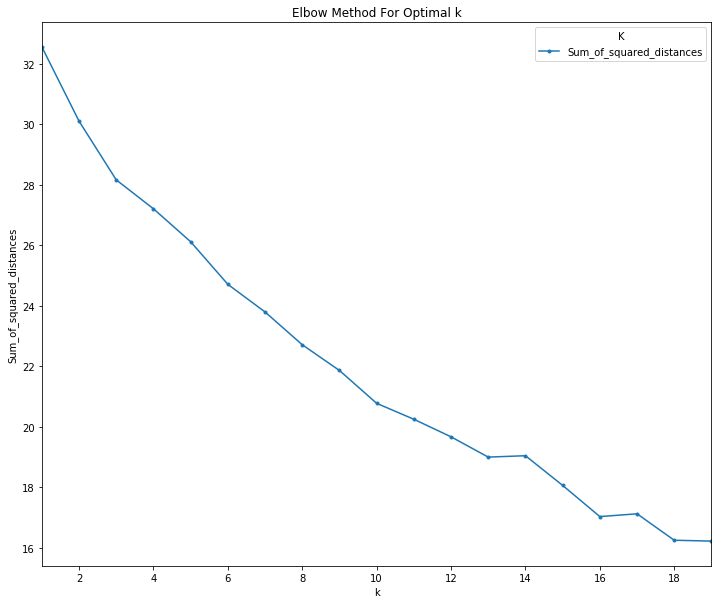

In [30]:
# Matplotlib and associated plotting modules

optimal_k.plot(kind = 'line', figsize = (12, 10), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

K value at 5 seems to be the best match

Below counters give a list of clusters count

In [193]:
import collections, numpy


for kclusters in range(1,5):

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hyderabad_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    print(kclusters)
    print(collections.Counter(kmeans.labels_))

1
Counter({0: 146})
2
Counter({1: 112, 0: 34})
3
Counter({1: 106, 0: 29, 2: 11})
4
Counter({2: 99, 1: 29, 3: 11, 0: 7})


In [452]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hyderabad_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.size

146

In [453]:
hyderabad_grouped_clustering.shape

(146, 154)

In [454]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [254]:
#neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

In [455]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,- Alwal,Gym,Grocery Store,Breakfast Spot,Department Store,Indian Restaurant,Bakery,Zoo,Diner,Farmers Market,Falafel Restaurant
1,1,- Macha Bollaram,ATM,Indian Restaurant,Farmers Market,Baseball Field,Bakery,Flea Market,Fast Food Restaurant,Falafel Restaurant,Exhibit,Electronics Store
2,1,36 - Neredmet,Fast Food Restaurant,Convenience Store,Pizza Place,Bakery,Zoo,Diner,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store
3,1,37 - Vinayakanagar,Pizza Place,Ice Cream Shop,Indian Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Fast Food Restaurant,Stadium,South Indian Restaurant,Chinese Restaurant,Brewery
4,1,38 - Moula-Ali,ATM,Pharmacy,Café,Dessert Shop,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store,Donut Shop,Diner


### once the clusters are determined using K-means algorith for k=5, clusters are joined to the dataframe

In [456]:
hyderabad_merged = Wards

hyderabad_merged = hyderabad_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Ward')
hyderabad_merged.dropna(inplace = True)
hyderabad_merged

,Ward,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kapra,17.488525,78.568172,1.0,Bakery,ATM,Pharmacy,Bar,Spanish Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store
1,Dr AS Rao Nagar,17.478478,78.550637,1.0,Café,Department Store,Clothing Store,Indian Restaurant,Fast Food Restaurant,Pizza Place,Bank,Farmers Market,Falafel Restaurant,Exhibit
3,Meerpet HB Colony,17.453117,78.564488,1.0,Neighborhood,Movie Theater,Garden,Mountain,Department Store,Falafel Restaurant,Exhibit,Electronics Store,Donut Shop,Diner
5,Nacharam,17.430809,78.559548,2.0,Indian Restaurant,Movie Theater,Electronics Store,Zoo,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Exhibit,Donut Shop
6,Chilukanagar,17.421812,78.561472,1.0,ATM,Playground,Department Store,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store,Donut Shop,Diner,Dessert Shop
7,Habsiguda,17.406623,78.543774,1.0,Indian Restaurant,Food,Cricket Ground,Park,Gas Station,Café,Athletics & Sports,Fast Food Restaurant,Stadium,Bakery
8,Ramanthapur,17.385277,78.527751,1.0,Jewelry Store,Zoo,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store,Donut Shop,Dessert Shop
9,Uppal,17.398377,78.558265,0.0,Light Rail Station,Convenience Store,Train Station,Zoo,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store
10,Nagole,17.371474,78.569502,1.0,Pharmacy,Food Court,Hotel Bar,Garden,Department Store,Zoo,Diner,Farmers Market,Falafel Restaurant,Exhibit
11,Mansoorabad,17.351337,78.562553,1.0,ATM,Restaurant,Bakery,Department Store,Hyderabadi Restaurant,Ice Cream Shop,Farmers Market,Falafel Restaurant,Exhibit,Electronics Store


### below code helps in analysis of the clusters to identify which all venues dominate the cluster

In [458]:
cluster0 = hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 0, hyderabad_merged.columns[[1] + list(range(1, hyderabad_merged.shape[1]))]]
cluster1 = hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 1, hyderabad_merged.columns[[1] + list(range(1, hyderabad_merged.shape[1]))]]
cluster2 = hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 2, hyderabad_merged.columns[[1] + list(range(1, hyderabad_merged.shape[1]))]]
cluster3 = hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 3, hyderabad_merged.columns[[1] + list(range(1, hyderabad_merged.shape[1]))]]
cluster4 = hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 4, hyderabad_merged.columns[[1] + list(range(1, hyderabad_merged.shape[1]))]]
cluster5 = hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 5, hyderabad_merged.columns[[1] + list(range(1, hyderabad_merged.shape[1]))]]

### Venue count is performed based on '1st Most Common Venue' and '2nd Most Common Venue'

In [459]:
#d=cluster0['1st Most Common Venue'].append(cluster0['2nd Most Common Venue']).append(cluster0['3rd Most Common Venue'])
d=cluster0['1st Most Common Venue'].append(cluster0['2nd Most Common Venue'])
Counter(d)

Counter({'Light Rail Station': 2,
         'Train Station': 7,
         'Resort': 2,
         'Gym': 1,
         'Hyderabadi Restaurant': 1,
         'Convenience Store': 1,
         'Middle Eastern Restaurant': 1,
         'Department Store': 1,
         'Food Truck': 1,
         'Hockey Arena': 1})

In [460]:
#d=cluster1['1st Most Common Venue'].append(cluster1['2nd Most Common Venue']).append(cluster1['3rd Most Common Venue'])
d=cluster1['1st Most Common Venue'].append(cluster1['2nd Most Common Venue'])
Counter(d)

Counter({'Bakery': 8,
         'Café': 17,
         'Neighborhood': 1,
         'ATM': 12,
         'Indian Restaurant': 25,
         'Jewelry Store': 1,
         'Pharmacy': 4,
         'Chinese Restaurant': 3,
         'Movie Theater': 3,
         'Business Service': 3,
         'Ice Cream Shop': 4,
         'Bus Station': 5,
         'Gym': 5,
         'Restaurant': 4,
         'Middle Eastern Restaurant': 2,
         'History Museum': 3,
         'Juice Bar': 3,
         'Smoke Shop': 1,
         'Zoo': 5,
         'Airport Service': 2,
         'Shopping Mall': 4,
         'Stationery Store': 1,
         'Garden': 2,
         'Snack Place': 5,
         'Fast Food Restaurant': 10,
         'Historic Site': 1,
         'Food': 2,
         'Construction & Landscaping': 1,
         'Multiplex': 3,
         'Hotel': 6,
         'Coffee Shop': 9,
         'Clothing Store': 5,
         'Pizza Place': 4,
         'Dessert Shop': 2,
         'Light Rail Station': 1,
         'Breakfast Spo

In [461]:
#d=cluster2['1st Most Common Venue'].append(cluster2['2nd Most Common Venue']).append(cluster2['3rd Most Common Venue'])
d=cluster2['1st Most Common Venue'].append(cluster2['2nd Most Common Venue'])
Counter(d)

Counter({'Indian Restaurant': 19,
         'Pizza Place': 1,
         'Dessert Shop': 1,
         'Train Station': 1,
         'Movie Theater': 1,
         'Vegetarian / Vegan Restaurant': 1,
         'Snack Place': 1,
         'Zoo': 2,
         'Fast Food Restaurant': 2,
         'Café': 5,
         'Restaurant': 2,
         'Food': 1,
         'Breakfast Spot': 1,
         'Smoke Shop': 1,
         'Clothing Store': 2,
         'Department Store': 1})

In [462]:
#d=cluster3['1st Most Common Venue'].append(cluster3['2nd Most Common Venue']).append(cluster3['3rd Most Common Venue'])
d=cluster3['1st Most Common Venue'].append(cluster3['2nd Most Common Venue'])
Counter(d)

Counter({'Pharmacy': 5,
         'Lake': 3,
         'ATM': 1,
         'Coffee Shop': 1,
         'Lighting Store': 1,
         'Asian Restaurant': 1,
         'Movie Theater': 2,
         'Zoo': 1,
         'Spa': 1})

In [463]:
#d=cluster4['1st Most Common Venue'].append(cluster4['2nd Most Common Venue']).append(cluster4['3rd Most Common Venue'])
d=cluster4['1st Most Common Venue'].append(cluster4['2nd Most Common Venue'])
Counter(d)

Counter({'Health & Beauty Service': 2, 'Diner': 2})

### Venue count is performed based on '1st Most Common Venue'

In [464]:
d=cluster0['1st Most Common Venue']
Counter(d)

Counter({'Light Rail Station': 1,
         'Train Station': 4,
         'Resort': 2,
         'Gym': 1,
         'Hyderabadi Restaurant': 1})

In [465]:
d=cluster1['1st Most Common Venue']
Counter(d)

Counter({'Bakery': 2,
         'Café': 9,
         'Neighborhood': 1,
         'ATM': 11,
         'Indian Restaurant': 16,
         'Jewelry Store': 1,
         'Pharmacy': 2,
         'Chinese Restaurant': 2,
         'Movie Theater': 2,
         'Business Service': 2,
         'Ice Cream Shop': 3,
         'Bus Station': 3,
         'Gym': 4,
         'Restaurant': 2,
         'Middle Eastern Restaurant': 2,
         'History Museum': 2,
         'Juice Bar': 1,
         'Smoke Shop': 1,
         'Zoo': 1,
         'Airport Service': 1,
         'Shopping Mall': 2,
         'Stationery Store': 1,
         'Garden': 2,
         'Snack Place': 2,
         'Fast Food Restaurant': 4,
         'Historic Site': 1,
         'Food': 1,
         'Construction & Landscaping': 1,
         'Multiplex': 2,
         'Hotel': 4,
         'Coffee Shop': 3,
         'Clothing Store': 3,
         'Pizza Place': 3,
         'Dessert Shop': 1,
         'Light Rail Station': 1,
         'Breakfast Spot'

In [466]:
d=cluster2['1st Most Common Venue']
Counter(d)

Counter({'Indian Restaurant': 18,
         'Pizza Place': 1,
         'Dessert Shop': 1,
         'Train Station': 1})

In [467]:
d=cluster3['1st Most Common Venue']
Counter(d)

Counter({'Pharmacy': 3,
         'Lake': 2,
         'ATM': 1,
         'Coffee Shop': 1,
         'Lighting Store': 1})

In [468]:
d=cluster4['1st Most Common Venue']
Counter(d)

Counter({'Health & Beauty Service': 2})

### Below chart is prepared using the information obtained from above few lines of code for 2nd Most common venue and 1st common venue

| Cluster #       | 2nd Most Common Venue     | 1st Most Common Venue     |
| :------------- | :----------: | -----------: |
|  0 | Train Station   | Train Station    |
|  1 | Bakery + Café + Indian Restaurant    | Café +Indian Restaurant    |
|  2 | Indian Restaurants + Others   | Indian Restaurants    |
|  3 | Pharmacy   | Pharmacy    |
| 4  | Health & Beauty Service | Health & Beauty Service  |

### Clusters are visualized on a map for each neighborhood using folium

In [469]:
# Create map
map_clusters = folium.Map(location=[hyd_lat, hyd_lng], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyderabad_merged['Latitude'], hyderabad_merged['Longitude'], hyderabad_merged['Ward'], hyderabad_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[(int(cluster)-1)],
        fill=True,
        fill_color=rainbow[(int(cluster)-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters